In [46]:
options(repr.plot.width=6.5, repr.plot.height=5, jupyter.plot_mimetypes='image/svg+xml')
source('common.r')
out <- function(obj) write(obj, stdout())

# Raw Mix

In [208]:
source('common.r')
d <- data.ipa.rawmix(where="datatype='counter' and ipa_duration=60 and (ipa_version LIKE 'v1.8%')")
out("data:   " + nrow(d))

d$grp <- d$bound
d$facet <- factor(d$honeycomb_mode)
d$x <- d$load

d$inconsistent <- d$counters_inconsistent_count
d$consistent <- d$counters_consistent_count
d$inconsistent_fraction <- d$inconsistent / (d$inconsistent + d$consistent)

d$fraction_immediate <- d$res_immediates_total / d$res_incrs_total

d$overall_latency_mean <- 
    d$timers_read_latency_mean * num(d$ipa_rawmix_counter_mix_read) + 
    d$timers_incr_latency_mean * num(d$ipa_rawmix_counter_mix_incr)

d$overall_rate_mean <- d$timers_read_latency_mean_rate + d$timers_incr_latency_mean_rate

s <- subset(d, 
  #  grepl('normal|slowpoke_flat', honeycomb_mode)
  # & mix == 'no_size' & grepl('\\{.*\\}', containers)
  grepl('v1.8.1#latency|v1.8#(con|tol)', x(ipa_version,ipa_bound))
)
out("subset: " + nrow(s))

data:   391
subset: 301


In [128]:
sql("SELECT load, ipa_bound, honeycomb_mode, round(res_cass_op_lat_mean,2) as cass_op, round(res_weak_read_lat_mean,2) as weak_read, round(res_strong_read_lat_mean,2) as strong_read, round(res_weak_write_lat_mean,2) as weak_write, round(res_strong_write_lat_mean,2) as strong_write FROM s WHERE ipa_bound LIKE '%tolerance%' ORDER BY honeycomb_mode")

,load,ipa_bound,honeycomb_mode,cass_op,weak_read,strong_read,weak_write,strong_write
1,128,tolerance:0.1,normal,2268.97,892.66,5.58,224.72,35.63
2,512,tolerance:0.1,normal,2458.28,970.32,6.29,248.27,31.49
3,2048,tolerance:0.1,normal,2383.21,940.47,7.16,239.25,33.28
4,128,tolerance:0.1,normal,2321,912.72,5.7,230.75,35.83
5,512,tolerance:0.1,normal,2451.73,967.86,5.53,245.71,32.36
6,2048,tolerance:0.1,normal,2413,950.37,5.63,244.11,32.63
7,128,tolerance:0.1,normal,2232.06,878.05,5.79,221.21,34.96
8,512,tolerance:0.1,normal,2428.7,958.84,5.99,244.64,31.67
9,2048,tolerance:0.1,normal,2493.47,984.05,6.82,251.26,32.24
10,16,tolerance:0.1,normal,248.39,91.96,5.63,17.76,36.49


In [ ]:
d$res_timers_cass_op_latency_mean

In [98]:
sql("SELECT load, ipa_bound, honeycomb_mode, timers_read_latency_mean as mean_lat, round(res_immediates_total/res_incrs_total,4) as immed, round(res_refreshes_total/res_incrs_total,4) as refresh, round(res_out_of_bounds_total/res_incrs_total,4) as out_of_bounds, res_incrs_total as incrs FROM s WHERE ipa_bound LIKE '%tolerance%' ORDER BY honeycomb_mode")

,load,ipa_bound,honeycomb_mode,mean_lat,immed,refresh,out_of_bounds,incrs
1,128,tolerance:0.1,normal,10.8350583628,0.8457,0.115,0.0393,80844
2,512,tolerance:0.1,normal,10.7887392097,0.8737,0.1073,0.019,87715
3,2048,tolerance:0.1,normal,10.3332068039,0.8664,0.1099,0.0237,84960
4,128,tolerance:0.1,normal,10.6475639419,0.849,0.113,0.038,83013
5,512,tolerance:0.1,normal,10.7098995027,0.8688,0.1083,0.0229,87357
6,2048,tolerance:0.1,normal,10.4813851971,0.8687,0.1091,0.0222,86668
7,128,tolerance:0.1,normal,10.5150428106,0.844,0.1161,0.0399,79605
8,512,tolerance:0.1,normal,10.8410422307,0.8717,0.1091,0.0193,86616
9,2048,tolerance:0.1,normal,10.6000521198,0.8732,0.1071,0.0197,89001
10,16,tolerance:0.1,normal,11.6872832573,0.2837,0.1107,0.6055,8145


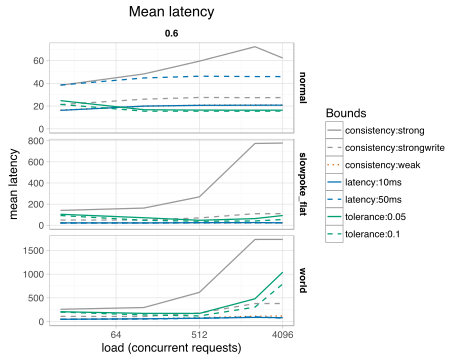

In [161]:
source('common.r')
ggplot(subset(s, x <= 4096), aes(
    x=x, y=overall_latency_mean, color=grp, fill=grp, linetype=grp, group=grp
))+
    stat_summary(geom='line', fun.y=mean, size=0.6)+
    ggtitle('Mean latency')+
    xlab('load (concurrent requests)')+
    ylab('mean latency')+
    scale_x_continuous(trans=log2_trans())+
    facet_grid(honeycomb_mode~ipa_zipf, scales="free")+
    theme_mine()+
    ipa.scales()

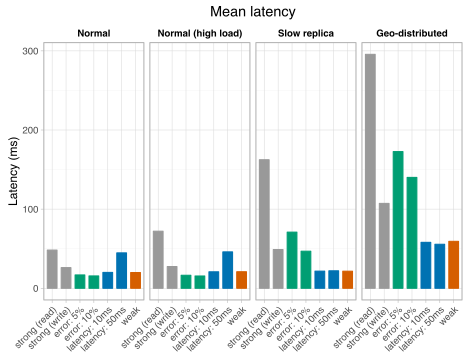

In [217]:
source('common.r')

ggplot(subset(s, !is.na(condition)), aes(
    x=grp, y = overall_latency_mean, color=grp, fill=grp, group=grp
))+
    stat_summary(geom='bar', fun.y=mean, size=0.5, width=0.7)+
    ggtitle('Mean latency')+
    xlab('load (concurrent requests)')+
    ylab('Latency (ms)')+
    facet_grid(~condition)+
    theme_mine()+
    theme.bar()+
    ipa.scales()

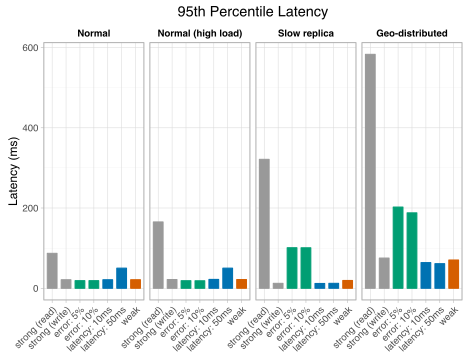

In [218]:
source('common.r')

ggplot(subset(s, !is.na(condition)), aes(
    x=grp, y = timers_read_latency_p95, color=grp, fill=grp, group=grp
))+
    stat_summary(geom='bar', fun.y=mean, size=0.5, width=0.7)+
    ggtitle('95th Percentile Latency')+
    ylab('Latency (ms)')+
    facet_grid(~condition)+
    theme_mine()+
    theme.bar()+
    ipa.scales()

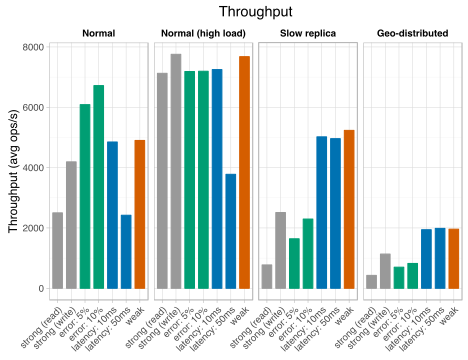

In [220]:
ggplot(subset(s, !is.na(condition)), aes(
    x=grp, y=overall_rate_mean, color=grp, fill=grp, group=grp
))+
    stat_summary(geom='bar', fun.y=mean, width=0.7)+
    ggtitle('Throughput')+
    ylab('Throughput (avg ops/s)')+
    facet_grid(~condition)+
    theme_mine()+
    theme.bar()+
    ipa.scales()

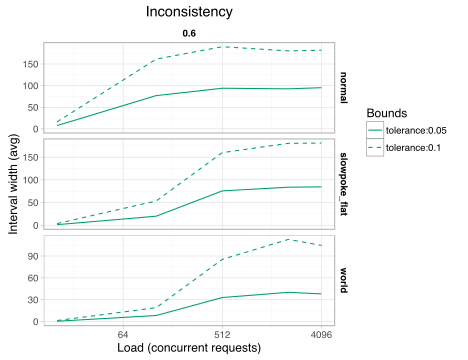

In [143]:
ggplot(subset(s, grepl('tolerance:',ipa_bound)), aes(
    x = x, y= histograms_interval_width_mean, color=grp, fill=grp, group=grp, linetype=grp
))+
    stat_summary(geom='line', fun.y=mean)+
    ggtitle('Inconsistency')+
    xlab('Load (concurrent requests)')+
    ylab('Interval width (avg)')+
    scale_x_continuous(trans=log2_trans())+
    facet_grid(honeycomb_mode~ipa_zipf, scales="free")+
    ipa.scales()+
    theme_mine()

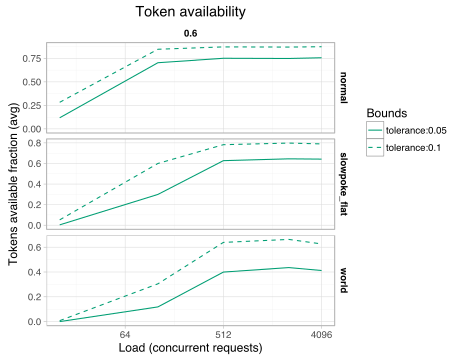

In [133]:
ggplot(subset(s, grepl('tolerance:',ipa_bound)), aes(
    x = x, y = fraction_immediate, color=grp, fill=grp, group=grp, linetype=grp
))+
    stat_summary(geom='line', fun.y=mean)+
    ggtitle('Token availability')+
    xlab('Load (concurrent requests)')+
    ylab('Tokens available fraction (avg)')+
    scale_x_continuous(trans=log2_trans())+
    facet_grid(honeycomb_mode~ipa_zipf, scales="free")+
    ipa.scales()+
    theme_mine()

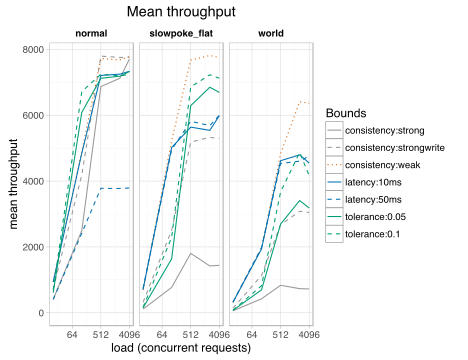

In [163]:
ggplot(subset(s, x <= 4096), aes(
    x=x, y=overall_rate_mean, color=grp, fill=grp, group=grp, linetype=grp
))+
    stat_summary(geom='line', fun.y=mean)+
    ggtitle('Mean throughput')+
    xlab('load (concurrent requests)')+
    ylab('mean throughput')+
    scale_x_continuous(trans=log2_trans())+
    facet_grid(~honeycomb_mode, scales="free")+
    ipa.scales()+
    theme_mine()

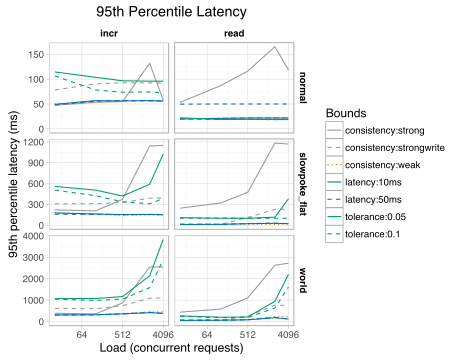

In [172]:
p = "95"
ggplot(melt.by(s, 'op', 'timers_(read|incr)_latency_p'+p+'$'), aes(
    x=x, y=value, color=grp, fill=grp, group=grp, linetype=grp
))+
    stat_summary(geom='line', fun.y=mean)+
    ggtitle(p+'th Percentile Latency')+
    xlab('Load (concurrent requests)')+
    ylab(p+'th percentile latency (ms)')+
    scale_x_continuous(trans=log2_trans())+
    facet_grid(honeycomb_mode~op, scale="free")+
    ipa.scales()+
    theme_mine()

In [ ]:
ggplot(s, aes(x=x, y=value, color=grp, fill=grp, group=grp))+
    stat_summary(geom='line', fun.y=mean)+
    scale_x_continuous(trans=log2_trans())+
    facet_wrap(~honeycomb_mode)+
    my_theme()

In [ ]:
read_ops <- c('contains', 'size')
levels <- c('strong', 'weak')

In [ ]:
for(op in read_ops) s['counters_'+op+'_weak_ratio'] <- s['counters_'+op+'_weak_count'] / (s['counters_'+op+'_strong_count']+s['counters_'+op+'_weak_count'])

m <- melt(s, measure=p('counters_'+read_ops+'_weak_ratio'))

m$op <- capply(m$variable, function(s) gsub('counters_(\\w+)_weak_ratio', '\\1', s))
m$fraction_weak <- m$value

ggplot(m, aes(x=x, y=fraction_weak, color=grp, fill=grp, group=grp))+
    stat_summary(geom='line', fun.y=mean)+
    scale_x_continuous(trans=log2_trans())+
    facet_grid(honeycomb_mode~op)+
    ggtitle('Fraction executed with weak consistency')+
    group.legend(title='Bounds')+
    xlab('Load (concurrent requests)')+
    ylab('Fraction of weakly consistent actions')+
    my_theme()

In [ ]:
tmp <- ddply(m, .(honeycomb_mode, ipa_bound, op, level, x), summarize, count=mean(count))
sql("SELECT * FROM tmp WHERE ipa_bound like 'latency%' ORDER BY honeycomb_mode, ipa_bound, op, x")

In [ ]:
m$grp <- m$level
ggplot(m, aes(x=x, y=count, color=grp, fill=grp, group=grp))+
    stat_summary(geom='line', fun.y=mean)+
    scale_x_continuous(trans=log2_trans())+
    facet_grid(honeycomb_mode~op~ipa_bound)+
    my_theme()

# Retwis

In [ ]:
d <- data.or.csv(
    csv = 'data/owl.csv',
    gen = function() data.owl()
)

In [ ]:
subset(d, duration == 60 & blockade == 'slow', select=c('c_reqs','ipa_consistency','op_rate'))

In [ ]:
d$x <- d$c_reqs
d$grp <- d$ipa_consistency
s <- subset(d, duration == 60 & blockade == 'slow' & !is.na(ipa_consistency))

ggplot(s, aes(x=x, y=op_rate, color=grp, fill=grp, group=grp))+
    stat_summary(geom='line', fun.y=mean)+
    xlab('system load (# concurrent requests)')+
    ylab('mean cassandra op latency (ms)')+
    my_theme()

In [ ]:
ggplot(s, aes(x=x, y=op_lat_mean, color=grp, fill=grp, group=grp))+
    stat_summary(geom='line', fun.y=mean)+
    xlab('system load (# concurrent requests)')+
    ylab('mean cassandra op latency (ms)')+
    my_theme()